In [1]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
## Matplotlib settings
## inspired by http://nipunbatra.github.io/2014/08/latexify/
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'magma',
    'axes.grid': False,
    'figure.dpi': 200,  # to adjust notebook inline plot size
    'savefig.dpi': 200,  # to adjust notebook inline plot size
    'axes.labelsize': 12, # fontsize for x and y labels (was 10)
    'axes.titlesize': 14,
    'font.size': 8, # was 10
    'legend.fontsize': 8, # was 10
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'text.usetex': True,
    'figure.figsize': [3.5, 2.625], # 4 x 3
#     'figure.figsize': [4*1.125, 3*1.125], # 4x3, full slide in keynote
    'font.family': 'serif',
    'figure.max_open_warning':100
}
mpl.rcParams.update(params)

## Get physical constants from Scipy
import scipy.constants as con
## Some useful numerical constants
hbar = con.physical_constants['Planck constant over 2 pi in eV s'][0]
c = con.physical_constants['speed of light in vacuum'][0]*1e2 #cm/m
k = con.physical_constants['Boltzmann constant in eV/K'][0]

import scipy.integrate as int

import scipy.io as sio

import scipy.optimize as opt

import scipy.special as spl

In [4]:
misloc_pack_path = os.path.join(
    os.path.sep,
    'Users',
    'chair',
    'Documents',
    'Academia',
    'SuperRes',
    'Biteen_colab',
    'Mispolarization',
    'python',
#     'gitted',
    )

sys.path.append(misloc_pack_path)

import misloc_mispol_package as mmp
import misloc_mispol_package.calc.coupled_dipoles as cp
import misloc_mispol_package.optics.anal_foc_diff_fields as aff

In [35]:
np.seterr(all='warn')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

Define some material parameters

Build temperature as function of location

In [224]:
bisph_c = lambda epsilon: (epsilon**(-2) - 1)**0.5

def zeta_1_of_eps(epsilon):
    """ With epsilon, half the unitless seperation defined by 
            seperation = 2 radius_1 / epsilon
        The argument of the returned arcsinh is half the foci-foci 
        distence (units of length) on the sphere radius. 
        Working with unitless parameters means 
            a/radius_1 = c
        and 
            a/radius_2 = c/(radius_2/radius_1)
        """
    c = bisph_c(epsilon)
    
    return np.arcsinh(c)
    

def zeta_2_of_eps(epsilon, l2_on_l1):
    """ With epsilon, half the unitless seperation defined by 
            seperation = 2 radius_1 / epsilon
        The argument of the returned arcsinh is half the foci-foci 
        distence (units of length) on the sphere radius. 
        Working with unitless parameters means 
            a/radius_1 = c
        and 
            a/radius_2 = c/(radius_2/radius_1)
        """
    c = bisph_c(epsilon)
    
    return -np.arcsinh(c/l2_on_l1)
        

def coeff_F_m(m, epsilon, l2_on_l1, q2_on_q1):
    """ Returns mth coefficient 
        """
    zeta_1 = zeta_1_of_eps(epsilon)
    zeta_2 = zeta_2_of_eps(epsilon, l2_on_l1)
    c = bisph_c(epsilon)

    numer = -2*2**(1/2)*c*(
        q2_on_q1*np.exp(
            -(m+(1/2))*np.abs(zeta_2))*np.cosh((m+3/2)*zeta_1)
        +
        np.exp(
            -(m+(1/2))*np.abs(zeta_1))*np.cosh((m+3/2)*zeta_2)
        )
    denom = ((m+1)*np.sinh((m+(3/2))*(zeta_1-zeta_2)))
              
    f_m = (
        numer
        /
        denom
        )
    
    return f_m
              

def coeff_tildeF_m(m, epsilon, l2_on_l1, q2_on_q1):
    """ Returns mth coefficient 
        """
    zeta_1 = zeta_1_of_eps(epsilon)
    zeta_2 = zeta_2_of_eps(epsilon, l2_on_l1)
    c = bisph_c(epsilon)

    numer = 2*2**(1/2)*c*(
        q2_on_q1*np.exp(
            -(m+(1/2))*np.abs(zeta_2))*np.sinh((m+3/2)*zeta_1)
        +
        np.exp(
            -(m+(1/2))*np.abs(zeta_1))*np.sinh((m+3/2)*zeta_2)
        )
    denom = ((m+1)*np.sinh((m+(3/2))*(zeta_1-zeta_2)))    
    
    f_m = (
        numer
        /
        denom
        )
    
    return f_m


def coeff_G2_m(m, epsilon, l2_on_l1):
    """ Returns mth coefficient 
        """
    zeta_1 = zeta_1_of_eps(epsilon)
    zeta_2 = zeta_2_of_eps(epsilon, l2_on_l1)
    
    g_m = ( 
        1 - (m/(m+1))*(
            (
                np.cosh((m+(3/2))*zeta_1)*np.sinh((m-(1/2))*zeta_2)
                -
                np.cosh((m+(3/2))*zeta_2)*np.sinh((m-(1/2))*zeta_1)
                )
            /
            np.sinh((m+(3/2))*(zeta_1-zeta_2))
            )
        )
    
    return g_m
        

def coeff_G1_m(m, epsilon, l2_on_l1):
    """ Returns mth coefficient 
        """
    zeta_1 = zeta_1_of_eps(epsilon)
    zeta_2 = zeta_2_of_eps(epsilon, l2_on_l1)
    
    g_m = ( 
        1 - (m/(m+1))*(
            (
                np.cosh((m+(3/2)*zeta_1))*np.cosh((m-(1/2))*zeta_2)
                -
                np.cosh((m+(3/2)*zeta_2))*np.cosh((m-(1/2))*zeta_1)
                )
            /
            np.sinh((m+(3/2))*(zeta_1-zeta_2))
            )
        )
    
    return g_m
             

def coeff_tildeG2_m(m, epsilon, l2_on_l1):
    """ Returns mth coefficient 
        """
    zeta_1 = zeta_1_of_eps(epsilon)
    zeta_2 = zeta_2_of_eps(epsilon, l2_on_l1)
    
    g_m = ( 
        1 - (m/(m+1))*(
            (
                -
                np.sinh((m+(3/2)*zeta_1))*np.sinh((m-(1/2))*zeta_2)
                +
                np.sinh((m+(3/2)*zeta_2))*np.sinh((m-(1/2))*zeta_1)
                )
            /
            np.sinh((m+(3/2))*(zeta_1-zeta_2))
            )
        )
    
    return g_m
        

def coeff_tildeG1_m(m, epsilon, l2_on_l1):
    """ Returns mth coefficient 
        """
    zeta_1 = zeta_1_of_eps(epsilon)
    zeta_2 = zeta_2_of_eps(epsilon, l2_on_l1)
    
    g_m = ( 
        1 - (m/(m+1))*(
            (
                -
                np.cosh((m+(3/2)*zeta_1))*np.cosh((m-(1/2))*zeta_2)
                +
                np.cosh((m+(3/2)*zeta_2))*np.cosh((m-(1/2))*zeta_1)
                )
            /
            np.sinh((m+(3/2))*(zeta_1-zeta_2))
            )
        )
    
    return g_m
             
def vec_F(m, epsilon, l2_on_l1, q2_on_q1):
    """ Vector F coefficient for vector recursion realtions.
        """
    tf_m = coeff_tildeF_m(m, epsilon, l2_on_l1, q2_on_q1)
    f_m = coeff_F_m(m, epsilon, l2_on_l1, q2_on_q1)
    
    vec_f = np.array([
        [tf_m,],
        [f_m,],
        ])
    return vec_f

def vec_G(m, epsilon, l2_on_l1):
    """ Vector G coefficient for vector recursion realtions.
        """
    g2 = coeff_G2_m(m, epsilon, l2_on_l1)
    g1 = coeff_G1_m(m, epsilon, l2_on_l1)         
    g2tilde = coeff_tildeG2_m(m, epsilon, l2_on_l1)         
    g1tilde = coeff_tildeG1_m(m, epsilon, l2_on_l1)
    
    vec_g = np.array([
        [g1tilde, -(1 - g2tilde)],
        [-(1 - g1), g2],
        ])
    return vec_g


def est_B_0(m_inf, epsilon, l2_on_l1, q2_on_q1):
    """ Estimates (returns) first coefficient B_0 from the limit 
            B_0 = -lim_{m->inf} H_m
        where 
            H_m = F_m + G_m H_{m-1} + (1 - G_m) H_{m-2}
            H_1 = F_1 + G_1 F_0 
            H_0 = F_0
        """
    zeta_1 = zeta_1_of_eps(epsilon)
    zeta_2 = zeta_2_of_eps(epsilon, l2_on_l1)
    
    F_0 = vec_F(0, epsilon, l2_on_l1, q2_on_q1)
    F_1 = vec_F(1, epsilon, l2_on_l1, q2_on_q1)
    
    G_1 = vec_G(1, epsilon, l2_on_l1)
    
    H_0 = F_0 
    if m_inf == 0:
        return -H_0
    H_1 = F_1 + G_1@F_0
    if m_inf == 1:
        return -H_1
    
    ## Iteratre through m vales from 2 to m_inf
    for m in range(2, m_inf+1):
        
        if m==2:
            H_m1 = H_1
            H_m2 = H_0
        
        G_m = vec_G(m, epsilon, l2_on_l1)
        F_m = vec_F(m, epsilon, l2_on_l1, q2_on_q1)
        
        H_m = F_m + G_m@H_m1 + (np.identity(2) - G_m)@H_m2
        
        ## Define for next iteration
        H_m1 = H_m
        H_m2 = H_m1
    
    b_0 = -H_m 
    return b_0

In [162]:
np.cosh((10+(3/2)*zeta_1_of_eps(2/3)))

46652.80321079634

In [163]:
ms = np.arange(10)
# b0s = np.zeros((2, ms))
eps = 2/3
b0s = np.asarray([est_B_0(n, eps, l2_on_l1=1., q2_on_q1=1.) for n in ms])
b0s = b0s.reshape(ms.shape[0], 2)
# plt.plot(ms, b0s, lw=0, marker='.')
# plt.title(f'Convergence of $B_0$ at $\epsilon = $ {eps}')
# plt.ylabel(f'$B_0$')
# plt.xlabel(f'$m$')


In [164]:
b0s

array([[-0.        ,  0.97719754],
       [-0.02088007,  1.08948038],
       [-0.02771244,  1.10743156],
       [-0.02771244,  1.1081481 ],
       [-0.02771244,  1.10823172],
       [-0.02771244,  1.10824189],
       [-0.02771244,  1.10824316],
       [-0.02771244,  1.10824332],
       [-0.02771244,  1.10824335],
       [-0.02771244,  1.10824335]])

In [165]:
def series_B_m(m, B_0, epsilon, l2_on_l1, q2_on_q1):
    """ Givens a column vector of the first coefficients 'B_0', 
        returns an array of shape (2, m+1) containing the B^(1) and 
        B^(2) coefficients from m=0 to m
        """
#     Bs = np.zeros((m+1, 2))
    Bs = np.zeros((2, m+1))
    Bs[:, [0]] = B_0
    
    if m==0:
        return Bs
    
    F_0 = vec_F(0, epsilon, l2_on_l1, q2_on_q1)
    B_1 = F_0 + B_0
    Bs[:, [1]] = B_1
    if m==1:
        return Bs
    
    ## Iteratre through m vales from 2 to m_inf
    for _m in range(2, m+1):
        
        B_m1 = Bs[:, [_m-1]]
        B_m2 = Bs[:, [_m-2]]

        G_m1 = vec_G(_m-1, epsilon, l2_on_l1)
        F_m1 = vec_F(_m-1, epsilon, l2_on_l1, q2_on_q1)
        
        Bs[:, [_m]] = F_m1 + G_m1@B_m1 + (np.identity(2) - G_m1)@B_m2
    
    return Bs
        

In [166]:
b0s[[-1]].T

array([[-0.02771244],
       [ 1.10824335]])

In [167]:
series_B_m(4, b0s[[-1]].T, .666, 1, 1)[0, None, :]

array([[-0.02771244, -0.02771244, -0.00692677, -0.000155  ,  0.0013696 ]])

In [174]:
def temp_unitless_biph_coords(
    zeta, 
    beta,
    l,
    epsilon,
    max_m,
    B_0, 
    l2_on_l1,
    q2_on_q1,
    return_terms=False
    ):
    """ Unitless temperature around 2 spheres of radii 'l' and 
        center-center seperation  as a function of bispherical 
        coordinates '2l/epsilon'. The expression is defined as a series 
        of coefficients B_m which are defined by recursion relation over 
        
        Assuming zeta and betas correspond to coordinate pairs
        """
    zeta = np.asarray(zeta)
    beta = np.asarray(beta)
    
    ## Get array of B_m coefficients, shape (2, max_m+1)
    array_B_m = series_B_m(
        max_m, 
        B_0, 
        epsilon,
        l2_on_l1,
        q2_on_q1,
        )
    
    m_array = np.arange(0, max_m+1, 1)

    ## zetas and betas are coordinate pairs, so only one coordinate 
    ## dimension is neccesary.
    legendre_P = np.zeros((len(beta), len(m_array)))
    
    for m in m_array:
        legendre_P[:, m] = spl.legendre(m)(np.cos(beta))
    
    sum_on_m_terms = (
        (
            array_B_m[0, None, :]
            *
            np.sinh((m_array[None, :]+0.5)*zeta[:, None])
            +
            array_B_m[1, None, :]
            *
            np.cosh((m_array[None, :]+0.5)*zeta[:, None])
            )
        *
        legendre_P
        )
    
    prefactor = np.sqrt(
        np.cosh(zeta)
        -
        np.cos(beta)
        )
    
    if return_terms:
        return prefactor[:, None]*sum_on_m_terms
    
    sum_on_m = np.sum(sum_on_m_terms, axis=-1)
    
    theta = (
        prefactor
        * 
        sum_on_m
        )
        
    return theta
    

Define coordinate transformation

In [175]:
def biph_transform(x, y, z, epsilon):
    
    x = np.asarray(x)[:, None, None]
    y = np.asarray(y)[None, :, None]
    z = np.asarray(z)[None, None, :]

    c = np.sqrt(epsilon**(-.2)-1)
    R = np.sqrt(x**2. + y**2. + z**2.)
    Q = np.sqrt((R**2. + c**2.)**2. - (2*c*z)**2.)

    zeta = np.arcsinh(2*c*z/Q).ravel()
    beta = np.arccos((R**2. - c**2.)/Q).ravel()
    
    return (zeta, beta)

In [288]:
## Define an epsilon 
# eps_test = .573
eps_test = 0.5

min_cartcoord, max_cartcoord = (-1, 1)
num_coords = 2000
coord_domain = np.linspace(min_cartcoord, max_cartcoord, num_coords)

x_test = coord_domain
y_test = [0]
z_test = coord_domain

zeta_test, beta_test = biph_transform(
    x_test, y_test, z_test, eps_test)

l2_on_l1_test = 1.5
q2_on_q1_test = 1

Trying to understand this implementation, try plotting zeta and beta

In [369]:
b0s = np.asarray([est_B_0(
    n, 
    eps_test, 
    l2_on_l1=l2_on_l1_test, 
    q2_on_q1=q2_on_q1_test
    ) for n in ms])

b0s = b0s.reshape(ms.shape[0], 2)

temp = temp_unitless_biph_coords(
    zeta = zeta_test, 
    beta = beta_test,
    l=1,
    epsilon=eps_test,
    max_m=3,
    B_0=b0s[[-1]].T,
    l2_on_l1=l2_on_l1_test,
    q2_on_q1=q2_on_q1_test,
    )

temp.shape

(4000000,)

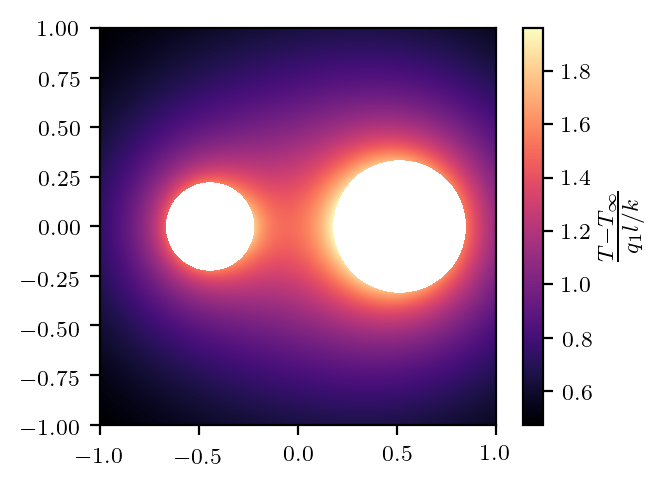

In [379]:
mask_condition = np.logical_or(
    (
        zeta_test.reshape((num_coords, num_coords))
        <
        zeta_2_of_eps(
            eps_test, l2_on_l1=l2_on_l1_test, #q2_on_q1=q2_on_q1_test
            )
        ), 
    (
        zeta_test.reshape((num_coords, num_coords))
        > 
        zeta_1_of_eps(
            eps_test, #l2_on_l1=l2_on_l1_test, q2_on_q1=q2_on_q1_test
            )
        )
    )

ma_temp = np.ma.masked_where(
    mask_condition,
    temp.reshape((num_coords, num_coords))
    )
plt.
plt.imshow(
    ma_temp[:, ::-1], 
    origin='lower', 
    extent=[min_cartcoord, max_cartcoord, min_cartcoord, max_cartcoord])
plt.colorbar(label=r'$\frac{T-T_\infty}{q_1 l/k}$')
# plt.xlabel()

### Trying to undestand why adding higher order terms in m breaks the plot. 

I will plot the difference between consebutive terms

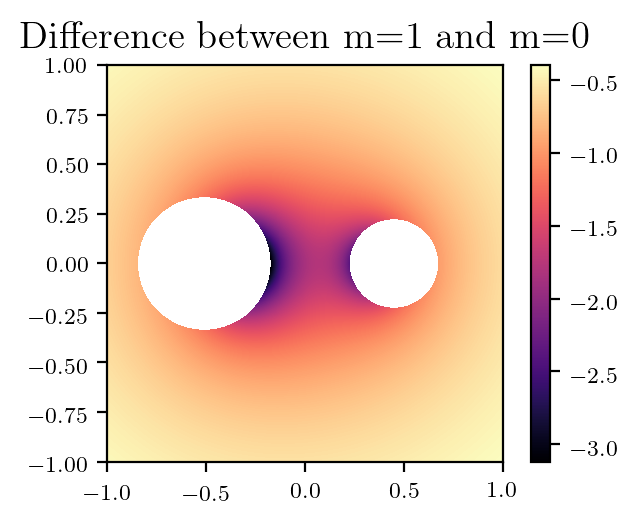

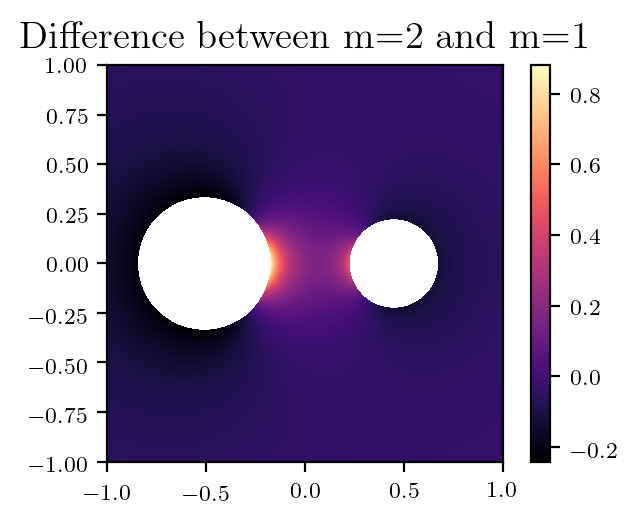

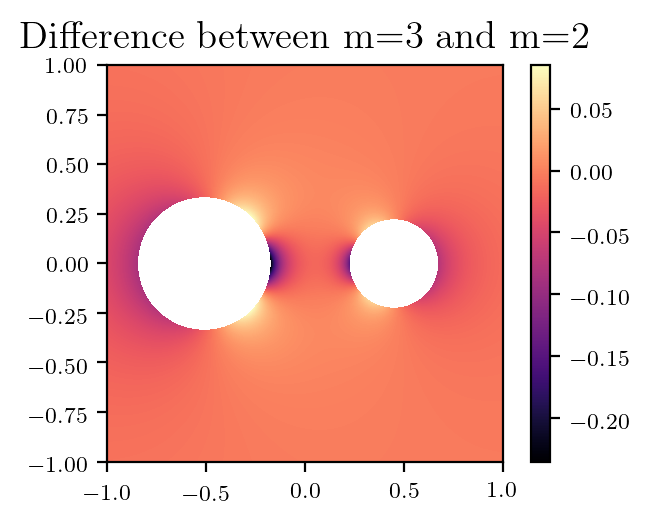

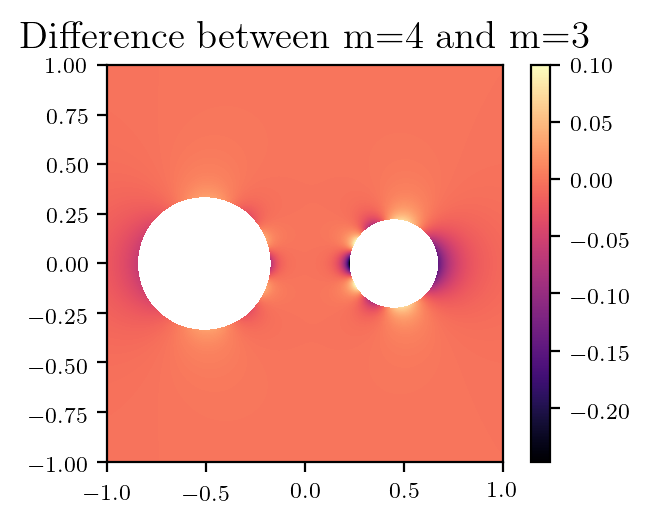

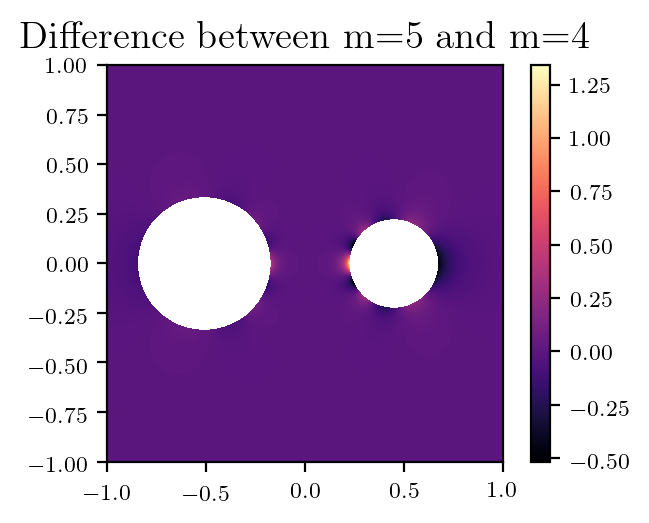

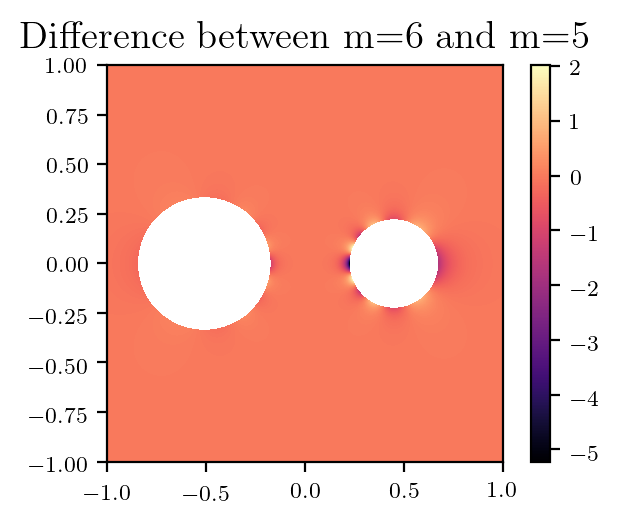

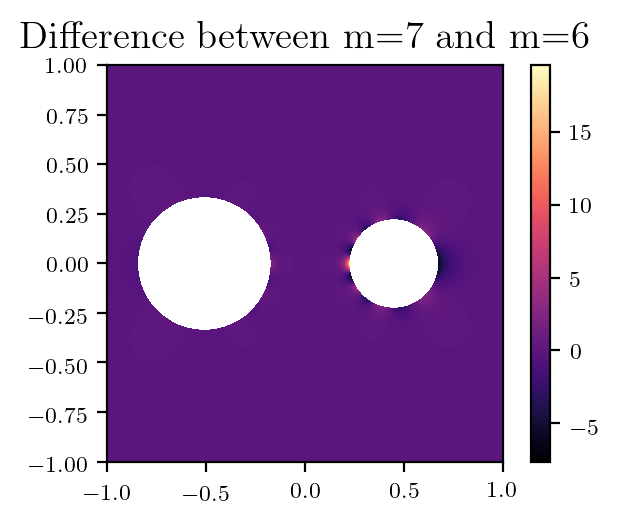

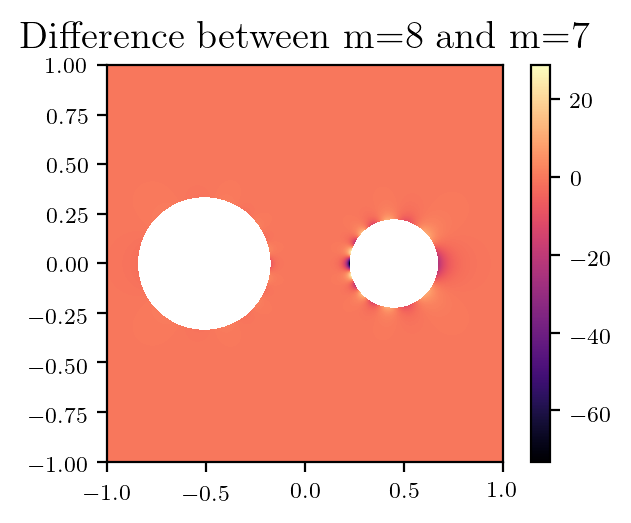

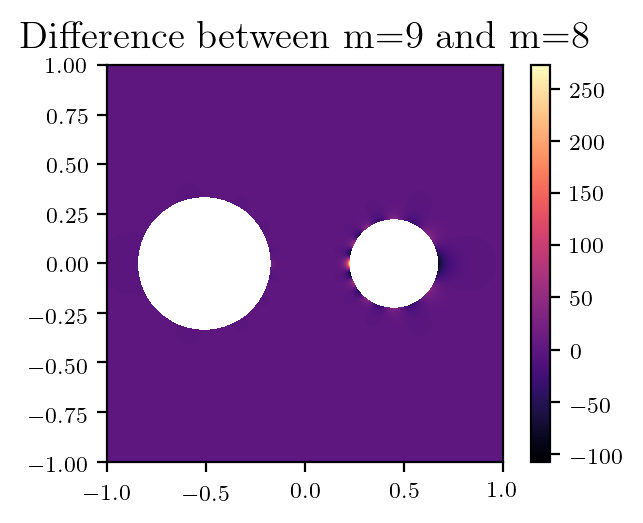

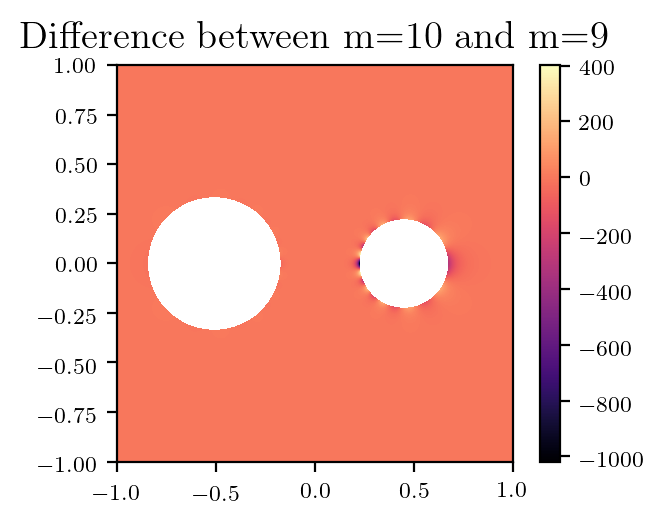

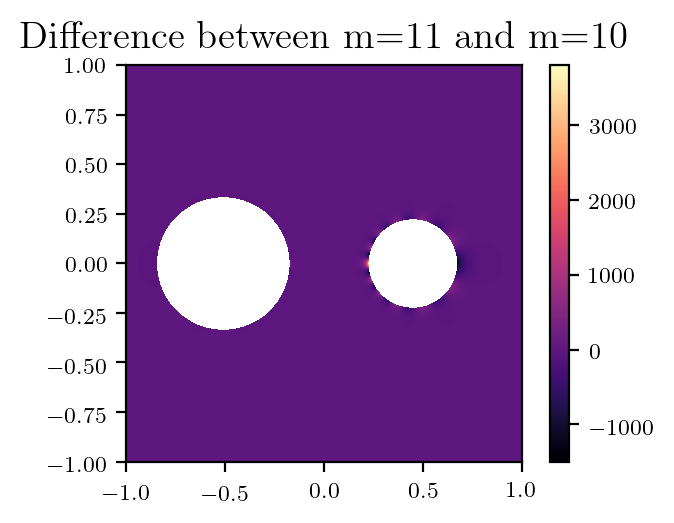

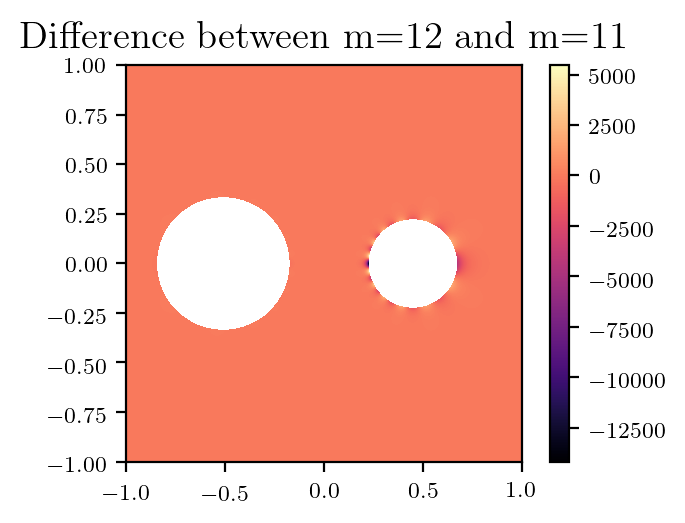

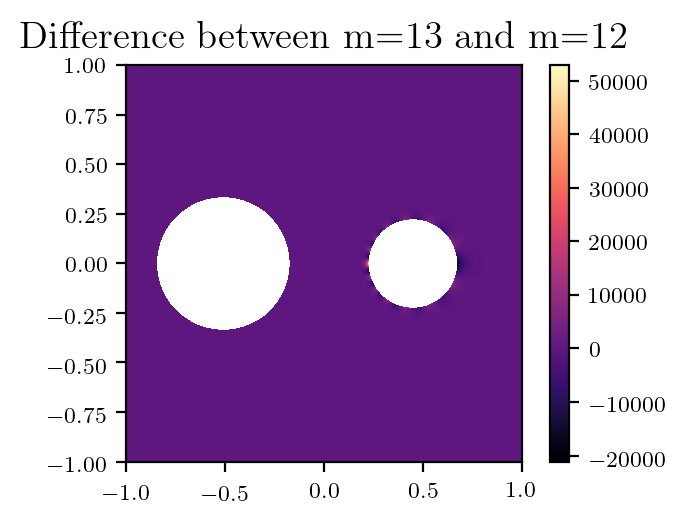

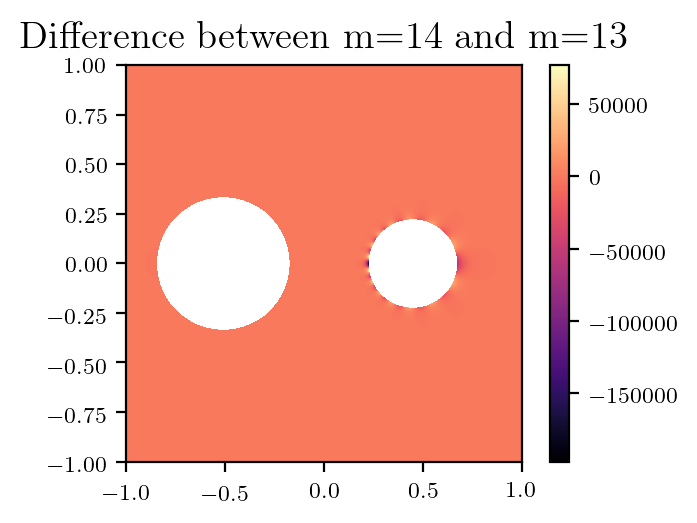

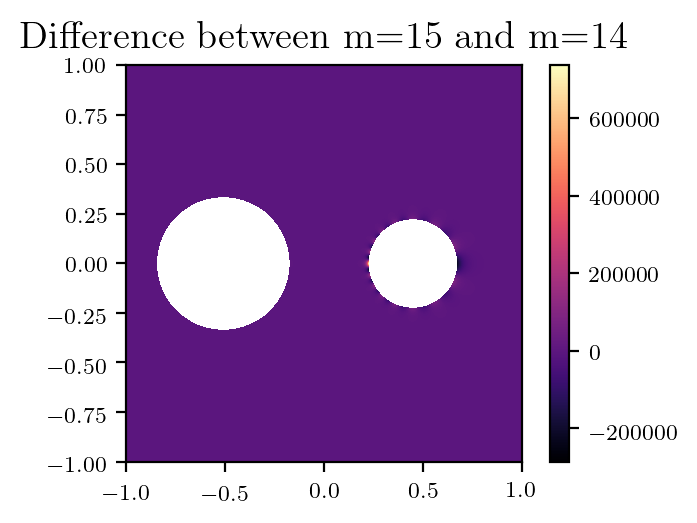

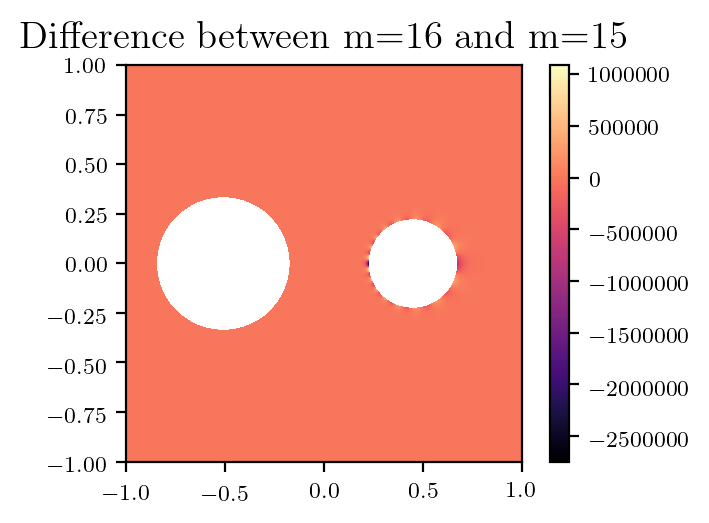

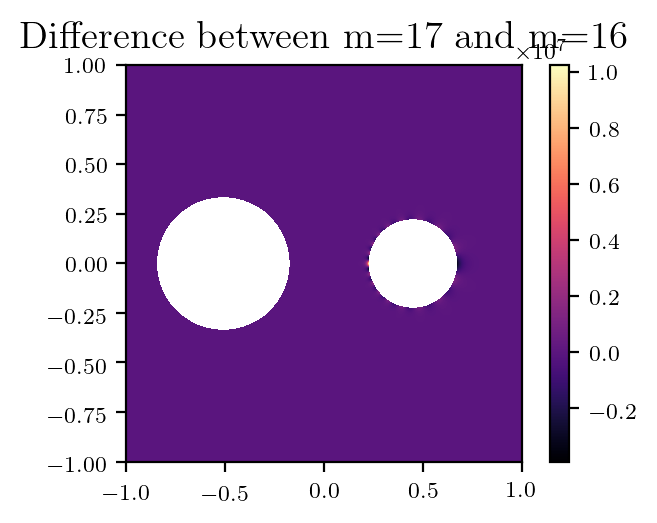

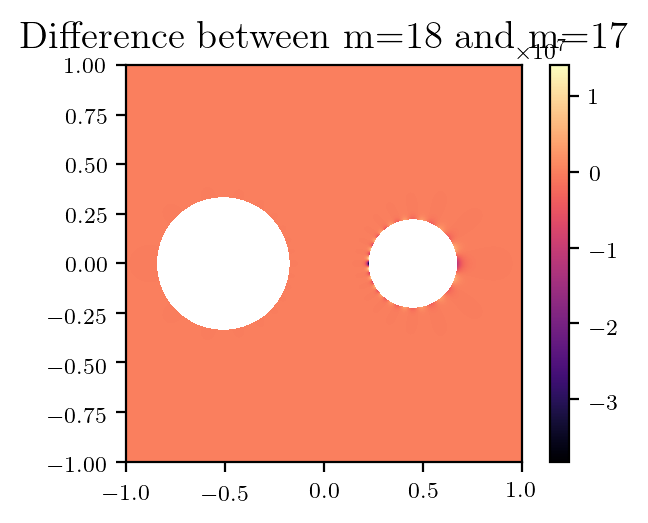

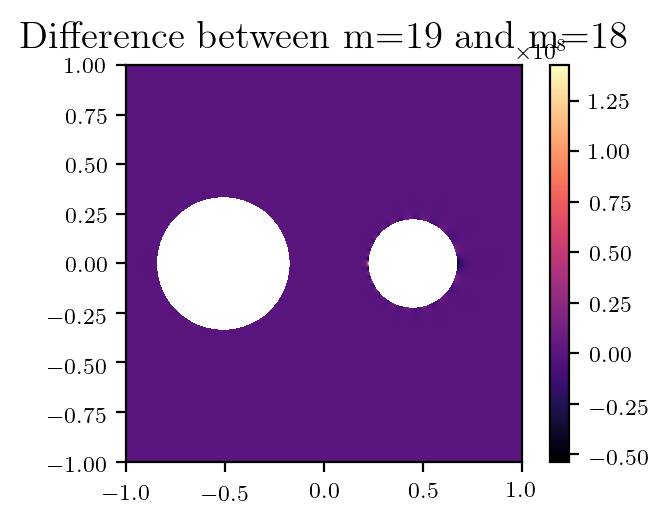

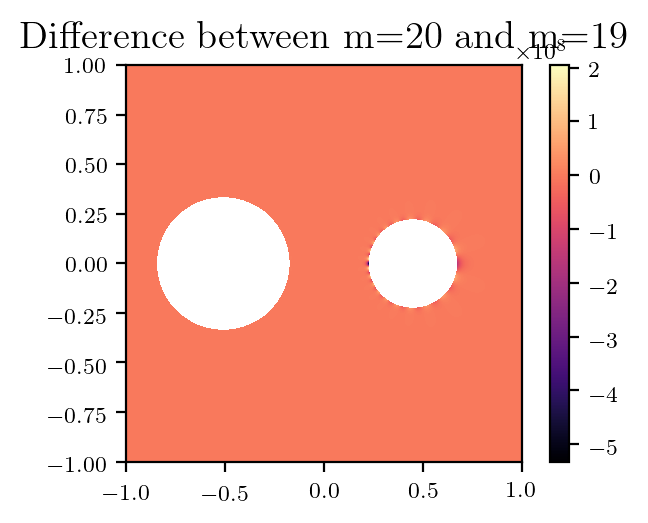

In [291]:
temp = temp_unitless_biph_coords(
    zeta = zeta_test, 
    beta = beta_test,
    l=1,
    epsilon=eps_test,
    max_m=20,
    B_0=b0s[[-1]].T,
    l2_on_l1=l2_on_l1_test,
    q2_on_q1=q2_on_q1_test,
    return_terms=1
    )
temp.shape

for i, diff in enumerate(np.diff(temp, axis=-1).T):

    _diff = np.ma.masked_where(
        mask_condition,
        diff.reshape((num_coords, num_coords))
        )

    plt.figure()
    plt.imshow(
        _diff, 
        origin='lower', 
        extent=[
            min_cartcoord, 
            max_cartcoord, 
            min_cartcoord, 
            max_cartcoord])
    plt.colorbar()
    plt.title(f'Difference between m={i+1:d} and m={i:d}')
    

## Calculating average surface temperature

In [294]:
def hetero_sph_unitless_temp(
    which_sphere, 
    epsilon,
    max_m,
    B_0, 
    l2_on_l1,
    q2_on_q1,
    return_terms=False
    ):
    """ Returns analytic result for the average surface temperature in
        terms of another seires of the Bm coefficients 
        """
    if which_sphere is 1:
        zeta_0 = zeta_1_of_eps(epsilon)
        _r = 1
    elif which_sphere is 2:
        zeta_0 = zeta_2_of_eps(epsilon, l2_on_l1)
        _r = l2_on_l1
    else: 
        raise ValueError("'which_sphere' arg must be 1 or 2.")
    
    ## Get array of B_m coefficients, shape (2, max_m+1)
    array_B_m = series_B_m(
        max_m, 
        B_0, 
        epsilon,
        l2_on_l1,
        q2_on_q1,
        )

    m_array = np.arange(0, max_m+1, 1)

    exp_factor = np.zeros(m_array.shape)
    for m in m_array:
        exp_factor[m] = np.exp(-(m+1/2)*np.abs(zeta_0))
    
    sum_on_m_terms = (
        (
            array_B_m[0, :]
            *
            np.sinh(
                (m_array+0.5)*zeta_0
                )
            +
            array_B_m[1, :]
            *
            np.cosh(
                (m_array+0.5)*zeta_0
                )
            )
        *
        exp_factor
        )
    
    area = 4*np.pi*_r**2
    prefactor = (
        2 * np.pi * bisph_c(epsilon)**2 * 2 * np.sqrt(2)
        /
        (area*np.sinh(np.abs(zeta_0)))
        )
    
    if return_terms:
        return prefactor*sum_on_m_terms
    
    sum_on_m = np.sum(sum_on_m_terms, axis=-1)
    
    theta_bar = (
        prefactor
        * 
        sum_on_m
        )
        
    return theta_bar


In [295]:
hetero_sph_unitless_temp(
    which_sphere=1,
    epsilon=eps_test,
    max_m=3,
    B_0=b0s[[-1]].T,
    l2_on_l1=l2_on_l1_test, 
    q2_on_q1=q2_on_q1_test,
    )


1.558225854274627

In [296]:
hetero_sph_unitless_temp(
    which_sphere=2,
    epsilon=eps_test,
    max_m=3,
    B_0=b0s[[-1]].T,
    l2_on_l1=l2_on_l1_test, 
    q2_on_q1=q2_on_q1_test,
    )

1.714586287362033

In [297]:
def eps_of_ccsep(num_radii):
    """ returns epsilon given number of radii connecting sphere centers
        """
    eps = 2/num_radii
    return eps

Make sure I am estimating B_0 correctly for each epsilon

In [298]:
def converged_B_0(epsilon, m_inf, l2_on_l1, q2_on_q1, tol=.01):
    """ Iterate m->inf until B0 changes by less then 'tol' of last 
        value """

    B0 = est_B_0(0, epsilon, l2_on_l1, q2_on_q1)

    for m in range(1, m_inf+1):
        
        new_B0 = est_B_0(m, epsilon, l2_on_l1, q2_on_q1)
        diff = new_B0 - B0

        if np.all(diff/new_B0 < tol):
            return new_B0
        
        else: B0 = new_B0
            
    raise ValueError("B_0 did not converge")
            

In [299]:
converged_B_0(2/3, 5, l2_on_l1_test, q2_on_q1_test)

array([[-0.54062918],
       [ 1.67442459]])

Text(0, 0.5, '$\\overline{\\theta}$')

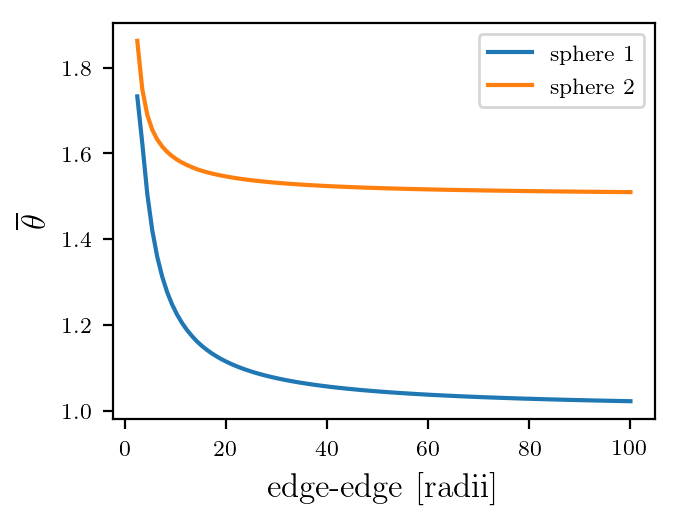

In [376]:
## Try this again 
radii = np.linspace(2.5, 100, 100)
epss = eps_of_ccsep(radii )

temps = np.zeros_like(epss)
temps = temps[None, :]*np.ones((2,1))

for i, e in enumerate(epss):
    temps[0, i] = hetero_sph_unitless_temp(
        which_sphere=1,
        epsilon=e, 
        max_m=3, 
        B_0=converged_B_0(e, 10, l2_on_l1=l2_on_l1_test, q2_on_q1=q2_on_q1_test),
        l2_on_l1=l2_on_l1_test, 
        q2_on_q1=q2_on_q1_test)
    temps[1, i] = hetero_sph_unitless_temp(
        which_sphere=2,
        epsilon=e, 
        max_m=3, 
        B_0=converged_B_0(e, 10, l2_on_l1=l2_on_l1_test, q2_on_q1=q2_on_q1_test),
        l2_on_l1=l2_on_l1_test, 
        q2_on_q1=q2_on_q1_test)
    

plt.plot(radii, temps[0], label='sphere 1')
plt.plot(radii, temps[1], label='sphere 2')    
plt.legend()
plt.xlabel(r'edge-edge [radii]')

plt.ylabel(r'$\overline{\theta}$')

In [303]:
radii[0]

2.5

Text(0, 0.5, '$\\overline{\\theta}$')

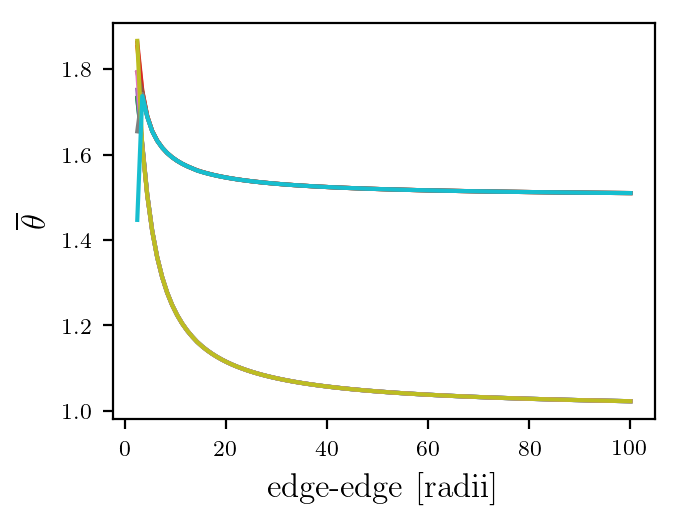

In [304]:
## Try this again 
radii = np.linspace(2.5, 100, 100)
epss = eps_of_ccsep(radii )
ms = np.arange(2, 7)

temps = np.zeros_like(epss)
temps = temps[None, None, :]*np.ones((len(ms), 2, 1,))

for i_ms, m in enumerate(ms):
    for i, e in enumerate(epss):
        temps[i_ms, 0, i] = hetero_sph_unitless_temp(
            which_sphere=1,
            epsilon=e, 
            max_m=m, 
            B_0=converged_B_0(e, 10, l2_on_l1=l2_on_l1_test, q2_on_q1=q2_on_q1_test),
            l2_on_l1=l2_on_l1_test, 
            q2_on_q1=q2_on_q1_test)
        temps[i_ms, 1, i] = hetero_sph_unitless_temp(
            which_sphere=2,
            epsilon=e, 
            max_m=m, 
            B_0=converged_B_0(e, 10, l2_on_l1=l2_on_l1_test, q2_on_q1=q2_on_q1_test),
            l2_on_l1=l2_on_l1_test, 
            q2_on_q1=q2_on_q1_test)
    
    plt.plot(radii, temps[i_ms, 0])
    plt.plot(radii, temps[i_ms, 1])
plt.xlabel(r'edge-edge [radii]')
plt.ylabel(r'$\overline{\theta}$')
# plt.xlim([0, 7.5])

(2, 7.5)

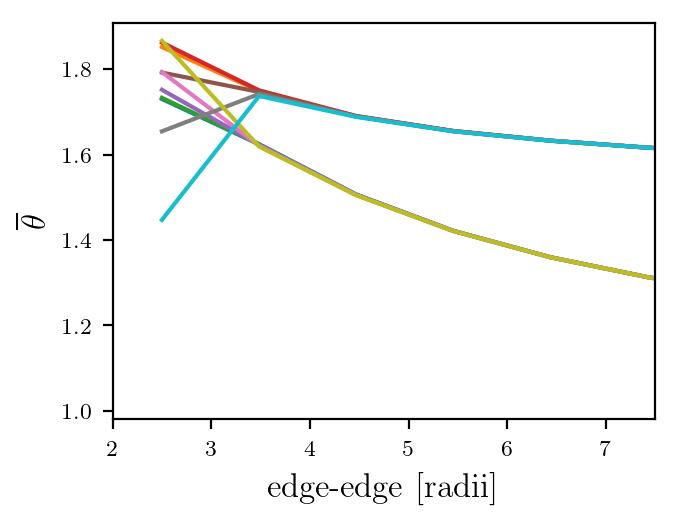

In [365]:
## Try this again 
radii = np.linspace(2.5, 100, 100)
epss = eps_of_ccsep(radii )
ms = np.arange(2, 7)

temps = np.zeros_like(epss)
temps = temps[None, None, :]*np.ones((len(ms), 2, 1,))

for i_ms, m in enumerate(ms):
    for i, e in enumerate(epss):
        temps[i_ms, 0, i] = hetero_sph_unitless_temp(
            which_sphere=1,
            epsilon=e, 
            max_m=m, 
            B_0=converged_B_0(e, 10, l2_on_l1=l2_on_l1_test, q2_on_q1=q2_on_q1_test),
            l2_on_l1=l2_on_l1_test, 
            q2_on_q1=q2_on_q1_test)
        temps[i_ms, 1, i] = hetero_sph_unitless_temp(
            which_sphere=2,
            epsilon=e, 
            max_m=m, 
            B_0=converged_B_0(e, 10, l2_on_l1=l2_on_l1_test, q2_on_q1=q2_on_q1_test),
            l2_on_l1=l2_on_l1_test, 
            q2_on_q1=q2_on_q1_test)
    
    plt.plot(radii, temps[i_ms, 0])
    plt.plot(radii, temps[i_ms, 1])
plt.xlabel(r'edge-edge [radii]')
plt.ylabel(r'$\overline{\theta}$')
plt.xlim([2, 7.5])

In [366]:
epss[1]

0.5739130434782609

In [367]:
radii[1]

3.484848484848485

In [314]:
eps_of_ccsep(4)

0.5

In [315]:
2/eps_of_ccsep(4)

4.0

# Model absorption to get heat flux

In [308]:
eps1 = -2.5676 + 1j*3.6391
n0 = 1.473
eps0 = n0**2

Eplane = (1.4444)**0.5 * 10**18 * 10**(-1)

def elec(dip_angle, x, y, k):
    """ Dipole field of an x oriented dipole"""
    
    E = aff.E_field(
        dipole_orientation_angle=dip_angle, 
        xi=x, 
        y=y, 
        k=k
        )
    
    return E/k**3


def g(
    d_angle,
    d, w, 
    scale=1, 
    n_b=n0,
    p1_angle=0, p2_angle=0,):
    
    ## rotate d vector
    R = cp.rotation_by(d_angle)
    d_col = (R @ np.array([[d, 0, 0]]).T).T
    
    ## Get coupling strength from misloc package
    G = cp.G(
        drive_hbar_w=hbar*w, 
        d_col=d_col, 
        n_b=n_b)
    ## but this was implemented to process multiple seperations d or 
    ## frequencies w, so returns shape (1, 3, 3)
    if G.shape[0] is 1:
        G = G[0]
    
    def p_hat(angle):
        return cp.rotation_by(angle) @ np.array([1,0,0])[:,None]
    
    g = p_hat(p1_angle).T @ G @ p_hat(p2_angle)
    
    return g[...,0,:]


def p_coupled(
    w, d,
    alpha, other_alpha,
    probe_E=Eplane):

    p = (
        (alpha*(1 + g(0, d, w,)*other_alpha)*probe_E)
        /
        (1 - alpha*other_alpha*g(0, d, w,)**2)
        ) 
    
    if len(p.ravel()) is 1:
        p = p.ravel()
    
    return p

def pow_abs_coupled(
    w, d,
    alpha, that_alpha,
    x_dip=None,
    x_that_dip=None,
    x_obs=None,    
    probe_E=Eplane,
    n_b=n0,
    imaging_mode=None
    ): 
    """ Defines the power absorbed by one of two coupled dipoles.
    
        Assumes scalar polarizabilities
        """
    x_obs = np.asarray(x_obs)
    
    if x_dip is None and x_that_dip is None:
        x_dip = -d/2
        x_that_dip = d/2
    
    if imaging_mode is None:
        raise ValueError("'imaging_mode' must be 'wf' or 'cf'")
        
    k = w*n_b/c    
    _g = g(0, d, w,)
    
    ## Set up incident field depensing on imaging modality
    if imaging_mode is 'cf':
        if x_obs is None:
            raise ValueError("Need 'x_obs' if 'imaging_mode'='cf'")
        ## Define spactially dependent driving field
        this_probe_E = elec(
            0, 
            x=x_dip-x_obs,
            y=0, 
            k=k
            )[0] * probe_E
        that_probe_E = elec(
            0, 
            x=x_that_dip-x_obs,
            y=0, 
            k=k
            )[0] * probe_E
    elif imaging_mode is 'wf':
        this_probe_E = probe_E
        that_probe_E = probe_E
        
    ## Work done on dipole by incident field and coupling
    E_tot_time_geom_coupling = (
        (this_probe_E + _g*that_alpha*that_probe_E)
        /
        (1 - alpha*that_alpha*_g**2)
        )
    
    p = alpha*E_tot_time_geom_coupling 
    
    alpha_inv_star_dot_p_star = np.conj(E_tot_time_geom_coupling) 
    
    term_1 = np.imag(p * alpha_inv_star_dot_p_star)
    
    ## Define work done on dipole by its own field (Larmore power)
    term_2 = (2/3) * k**3. * np.abs(p)**2. 
    
    _pow_abs = w/2 * (term_1 - term_2)
    
    return _pow_abs

In [309]:
## Test 
pow_abs_coupled(
    x_obs=[1, 2, 3],
    x_dip=0,
    x_that_dip=0,
    w=1, 
    d=1,
    alpha=1, 
    that_alpha=1,
    probe_E=Eplane,
    n_b=n0,
    imaging_mode='cf'
    )

array([-253.82233713, -253.82233713, -253.82233713])

In [339]:
pow_abs_coupled(
    x_obs=1,
    x_dip=0,
    x_that_dip=0,
    w=np.array([1, 2, 3])/hbar, 
    d=1,
    alpha=1, 
    that_alpha=1,
    probe_E=Eplane,
    n_b=n0,
    imaging_mode='cf'
    )

array([[-1.61372448e+34, -1.22703457e+34, -7.25804077e+33],
       [-4.03434156e+33, -3.06760952e+33, -1.81452385e+33],
       [-1.79302795e+33, -1.36337232e+33, -8.06449315e+32]])

That doesnt seem to be working. 

Thinking I can just use this simpler implemention of the coupled dipoles with the sphere polarizability from `mmp.calc.cp`
```
cp.sparse_ret_sphere_polarizability_Drude(w, eps_inf, w_p, gamma,
    eps_b, a, isolate_mode=None)
```

But the naive function I wrote takes a scalar polarizability

In [358]:
a1 = 10
a2 = 15

# del_d = 4*a1

d = 4*a1

hw = 2.2
sensorsize_nm = 1000

In [359]:
def alpha_1_of_hw(hw):
    return cp.sparse_ret_sphere_polarizability_Drude(
        w=hw/hbar, 
#         eps_inf=14.2, 
#         w_p=10.0/hbar, 
#         gamma=0.20/hbar,
#         eps_b=1.33**2., 
        a=a1*1e-7, 
        eps_inf=9.82335326,  # eps_inf
        w_p=9.06705560/hbar,  # w_p
        gamma=0.0334860149/hbar,  # gamma
        eps_b=1.33**2.,  # eps_b
#         a=41*1e-7
        )

def alpha_2_of_hw(hw):
    return cp.sparse_ret_sphere_polarizability_Drude(
        w=hw/hbar, 
        eps_inf=9.82335326,  # eps_inf
        w_p=9.06705560/hbar,  # w_p
        gamma=0.0334860149/hbar,  # gamma
        eps_b=1.33**2.,  # eps_b
        a=a2*1e-7, 
        )

In [360]:
alpha_1_of_hw(np.array([1, 2, 3])).shape

(3, 3, 3)

Text(0.5, 1.0, 'Scattering')

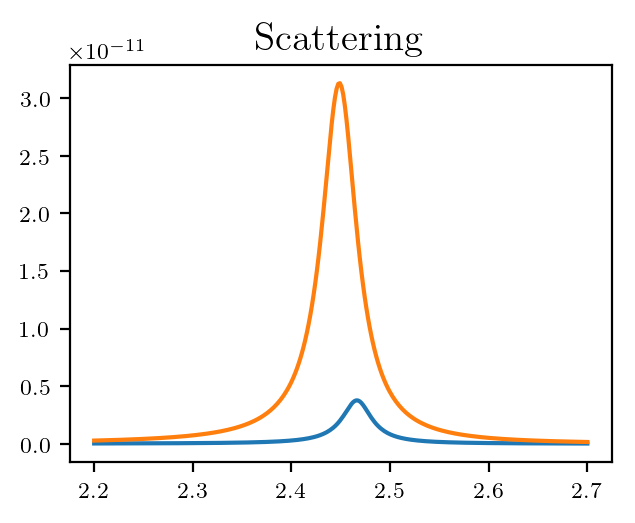

In [364]:
plot_hws = np.linspace(2.2, 2.7, 300)

sphere_1_scattering = (
    cp.sigma_prefactor(w=plot_hws/hbar, eps_b=1.33**2.)
    *
    np.abs(alpha_1_of_hw(plot_hws)[:, 0, 0])**2.
    )
sphere_2_scattering = (
    cp.sigma_prefactor(w=plot_hws/hbar, eps_b=1.33**2.)
    *
    np.abs(alpha_2_of_hw(plot_hws)[:, 0, 0])**2.
    )

plt.plot(plot_hws, sphere_1_scattering)
plt.plot(plot_hws, sphere_2_scattering)
plt.title("Scattering")

In [317]:
alpha_1 = cp.sparse_ret_sphere_polarizability_Drude(
    w=hw/hbar, 
    eps_inf=14.2, 
    w_p=10.0/hbar, 
    gamma=0.20/hbar,
    eps_b=1.33**2., 
    a=a1*1e-7, 
    )

alpha_2 = cp.sparse_ret_sphere_polarizability_Drude(
    w=hw/hbar, 
    eps_inf=14.2, 
    w_p=10.0/hbar, 
    gamma=0.20/hbar,
    eps_b=1.33**2., 
    a=a2*1e-7, 
    )

Text(0.5, 1.0, 'Power abs. by 10 nm and 15 nm spheres')

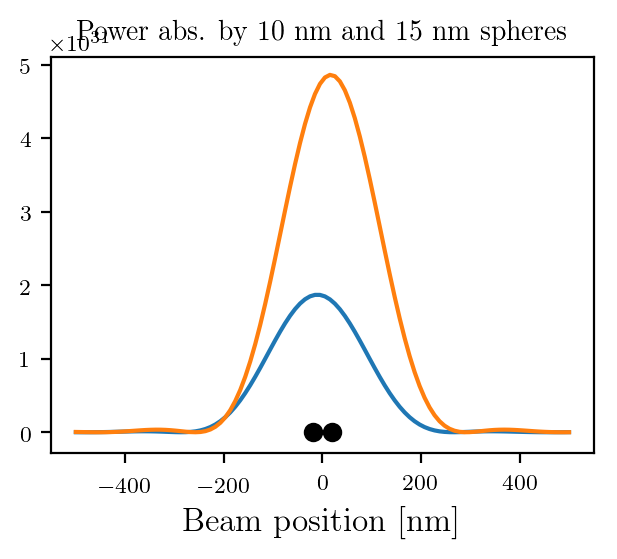

In [319]:
obs_points = np.linspace(-sensorsize_nm/2, sensorsize_nm/2, 100)*1e-7

pow_test_1 = pow_abs_coupled(
    x_obs=obs_points,
    x_dip=-d*1e-7/2,
    x_that_dip=d*1e-7/2,
    w=hw/hbar, 
    d=d*1e-7,
    alpha=alpha_1[0,0], 
    that_alpha=alpha_2[0,0],
    probe_E=Eplane,
    n_b=n0,
    imaging_mode='cf'
    )

pow_test_2 = pow_abs_coupled(
    x_obs=obs_points,
    x_dip=+d*1e-7/2,
    x_that_dip=-d*1e-7/2,
    w=hw/hbar, 
    d=d*1e-7,
    alpha=alpha_2[0,0], 
    that_alpha=alpha_1[0,0],
    probe_E=Eplane,
    n_b=n0,
    imaging_mode='cf'
    )

plt.plot(obs_points*1e7, pow_test_1)
plt.plot(obs_points*1e7, pow_test_2)
plt.xlabel('Beam position [nm]')
## plot positions
plt.scatter(
    np.asarray([-1, 1])*d/2,
    [0,0],
    c='k')
plt.title('Power abs. by 10 nm and 15 nm spheres', fontsize=10)



Realizing that I can't use the results from the paper for confocal imaging because the heat flux out of the two spheres is not the same. Might be time to do some math, unless I want to integrate with Widefield... I guess it might be worth it. But I am less interested in that.

In [ ]:
## Calculate temperature
## Try this again 
radii = d/40*1e-7
epss = eps_of_ccsep(radii)

temps = np.ones_like(obs_points) * two_sph_unitless_temp(
        epsilon=e, 
        max_m=3, 
        B_0=converged_B_0(e, 10))

for i, e in enumerate(obs_points):
    temps[i] = two_sph_unitless_temp(
        epsilon=e, 
        max_m=3, 
        B_0=converged_B_0(e, 10))
    
plt.plot(radii, temps)
plt.xlabel(r'edge-edge [radii]')

plt.ylabel(r'$\overline{\theta}$')